In [1]:
%matplotlib notebook

from matplotlib.pyplot import *;
from numpy import *;
from numpy.linalg import *;
from scipy.linalg import *;
from control.matlab import *;
import matplotlib.pyplot as plt

In [2]:
# Parametri sustava
Jxx = 5.17e-3;
Jyy = 5.17e-3;
Jzz = 1.7e-2;
m = 0.8;
l = 0.3;
b = 2e-4;
d = 7e-5;
g = 9.81;

# Pomoćne matrice
I3 = eye(3);
I4 = eye(4);
I12 = eye(12);
O412 = matrix(zeros((4, 12)));
O124 = matrix(zeros((12, 4)));
O81 = matrix(zeros((8, 1)));
O34 = matrix(zeros((3, 4)));
O31 = matrix(zeros((3, 1)));
O33 = matrix(zeros((3, 3)));
O13 = matrix(zeros((1, 3)));
O14 = matrix(zeros((1, 4)));
O41 = matrix(zeros((4, 1)));
O43 = matrix(zeros((4, 3)));
O44 = matrix(zeros((4, 4)));
O32 = matrix(zeros((3, 2)));
O12 = matrix(zeros((1, 2)));
O36 = matrix(zeros((3, 6)));
O16 = matrix(zeros((1, 6)));
O18 = matrix(zeros((1, 8)));
O116 = matrix(zeros((1, 16)));
O128 = matrix(zeros((12, 8)));
O416 = matrix(zeros((4, 16)));

In [3]:
# Definicija LTI sustava

A = block([[O34, O31, O31, I3, O33], 
           [O34, O31, O31, O33, I3], 
           [O13, 0, g, O14, O13], 
           [O13, -g, 0, O14, O13],
           [O44, O41, O41, O43, O43]
          ]);

B = block([[O81, O81, O81, O81],
           [matrix(diag((1 / m, 1 / Jxx, 1 / Jyy, 1 / Jzz)))]
          ]);

C = block([[I3, O32, O31, O36],
          [O13, O12, 1, O16]]);

D = O44;

sys_G = ss(A, B, C, D);
print(sys_G);

A = [[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -9.81  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

B = [[  0.           0.           0.           0.        ]
 [  0.           0.           0.   

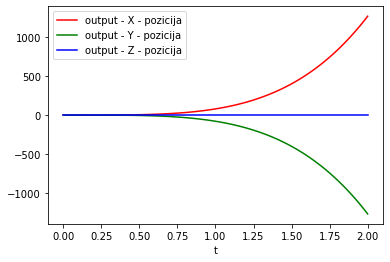

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Simulacija sustava, provjera stabilnosti

t_max = 2; t_intervals = 100; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);

# Input
u = block([[zeros((100, 1)), ones((100, 3))]]);
#u = zeros((100, 4))
# Početno stanje.
x0 = matrix(zeros((12, 1)));

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout, tout, xout] = lsim(sys_G, u, t, x0);

%matplotlib inline

f = figure;
plot(tout, yout[:, 0], 'r-', label = 'output - X - pozicija');
plot(tout, yout[:, 1], 'g-', label = 'output - Y - pozicija');
plot(tout, yout[:, 2], 'b-', label = 'output - Z - pozicija');
xlabel('t');
legend();
show();

'''
Da se zaključiti iz slike da sustav nije stabilan. Provjerimo polove transfer funkcije.
'''

print(pole(sys_G))

In [5]:
tmp_A = block([[A, O124], 
               [-C, O44]]);

tmp_B = block([[B], 
               [-D]]);

tmp_C = block([[C, O44], 
               [O412, I4],
               [O416]]);

tmp_D = block([[D], 
               [O44], 
               [I4]]);

sys_intG = ss(tmp_A, tmp_B, tmp_C, tmp_D);

#sys_intG = series(sys_int, sys_G);

Q = matrix(diag([0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 100, 100]));
R = matrix(eye(4));

[K, X, Lam] = lqr(sys_intG, Q, R);

# Spajanje sustava
Kx = K[:, 0:12];
Kni = K[:, 12:16];
Q.shape

(16, 16)

In [6]:
# Složimo sustav

# 1) Razdvojimo sys_G na sys_G1 i sys_G2 td series(sys_G1, sys_G2) daju sys_G (tj izlaz
# od sys_G1 su stanja i ulaz, a izlaz od sys_G2 je izlaz od sys_G)

tmp_C = block([[I12], 
               [O412]]);

tmp_D = block([[O124], 
               [I4]]);

sys_G1 = ss(A, B, tmp_C, tmp_D);
sys_G2 = ss(0, O116, O41, block([[C, D]]));

sys_Kx  = ss(0, O116, O41, block([[Kx, O44]])); 
sys_Kni = ss(0, O14, O41, Kni);

# Kreiramo pomocne matrice za integrator
M = [[[1], [0], [0], [0]],
     [[0], [1], [0], [0]],
     [[0], [0], [1], [0]],
     [[0], [0], [0], [1]]];

N = [[[1, 0], [1], [1], [1]],
     [[1], [1, 0], [1], [1]],
     [[1], [1], [1, 0], [1]],
     [[1], [1], [1], [1, 0]]];

sys_int = tf(M, N);

sys_Id = ss(0, O14, O41, I4);
# Možemo složiti konačni sustav

sys_T1 = feedback(sys_G1, sys_Kx);
sys_T2 = series(sys_int, sys_Kni);
sys_T3 = series(sys_T2, sys_T1);
sys_T4 = series(sys_T3, sys_G2);
sys_G_servo = feedback(sys_T4, sys_Id, 1);

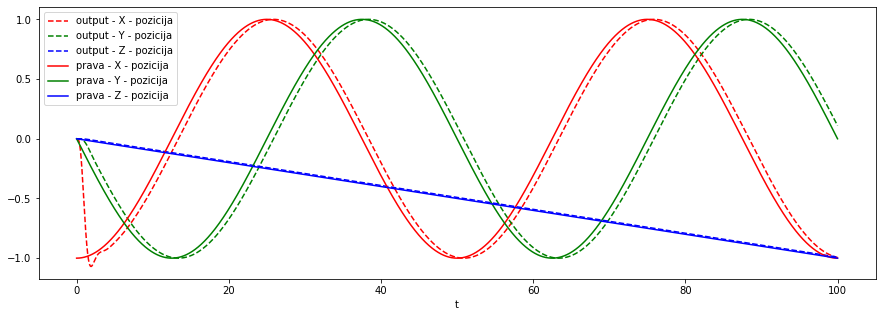

In [7]:
# a) Radimo simulaciju sustava za ulaz koji je jednak spirali

t_max = 100; t_intervals = 10000; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);

def uu(t):
    return [cos(t / t_max * 4 * pi), sin(t / t_max * 4 * pi), t / t_max, 0];

# Input
u = matrix(list(map(uu, t)));
# Početno stanje.
x0 = matrix(zeros((16, 1)));

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout, tout, xout] = lsim(sys_G_servo, u, t, x0);

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 5)
f = figure;
plot(tout, yout[:, 0], 'r--', label = 'output - X - pozicija');
plot(tout, yout[:, 1], 'g--', label = 'output - Y - pozicija');
plot(tout, yout[:, 2], 'b--', label = 'output - Z - pozicija');
plot(tout, -u[:, 0], 'r-', label = 'prava - X - pozicija');
plot(tout, -u[:, 1], 'g-', label = 'prava - Y - pozicija');
plot(tout, -u[:, 2], 'b-', label = 'prava - Z - pozicija');
xlabel('t');
legend();
show();

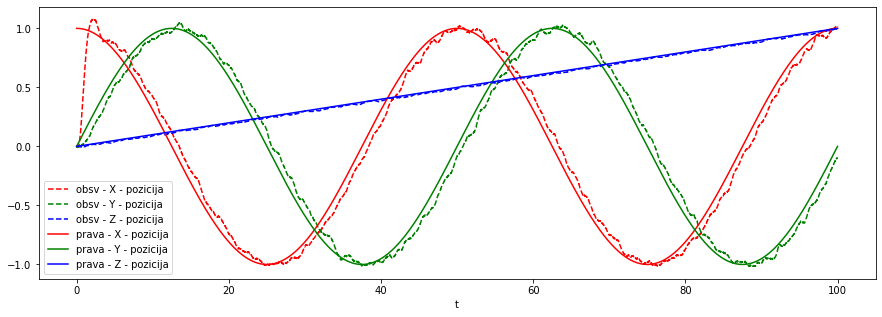

In [8]:
# b) kako ne znamo stanja od sys_G tako ne mozemo ga razdvojiti na sys_G1 i sys_G2

t_max = 100; t_intervals = 10000; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);

def uu(t):
    return [cos(t / t_max * 4 * pi), sin(t / t_max * 4 * pi), t / t_max, 0];

# Input
u = matrix(list(map(uu, t)));
# Početno stanje.
x0 = matrix(zeros((12, 1)));

# Šum u ulazu
sigma_w = 0.04;
w = sigma_w * matrix(random.randn(12, t_intervals));

# Šum u mjerenju
sigma_v = 0.02;
v = sigma_v * matrix(random.randn(4, t_intervals));

# Simulacija.

Sigma_w = sigma_w * matrix(eye(12));
Sigma_v = sigma_v * matrix(eye(4));
F = matrix(eye(12));

Sigma = care(A.T, C.T, F * Sigma_w * F.T, Sigma_v)[0];

# Kalmanov 'gain'

KG = Sigma * C.T * inv(Sigma_v);

# Aproksimacija stanja je dana sa
# x_KF'(t) = A*x_KF(t) + B*u(t) + KG*(y(t) - y_KF(t))
# y_KF(t) = C*x_KF(t) + D*u(t)

x_real = matrix(zeros((12, t_intervals))); # Stvarno stanje.
x_kalm = matrix(zeros((12, t_intervals))); # Ono što vidi promatrač - Kalmanov filtar.
y_kalm = matrix(zeros((4, t_intervals))); # Aproksimacije za output koje radi KF.
y = matrix(zeros((4, t_intervals))); # Mjerenja (simuliramo).

x_real[:, 0] = x0;
x_kalm[:, 0] = x0; # Ne zna stvarno stanje.
u_K = 0; # Izlaz iz kontrolera u trenutku 0.
ni = matrix(zeros((4, 1)))

for k in range(0, t_intervals - 1):
    # Ulaz u trenutku dt*k je zbroj vanjske sile i onog što daje kontroler.
    
    ni = ni + dt * (u[k, :].T - y_kalm[:, k]);
    
    ulaz = -Kni * ni - u_K;
    
    # Što se stvarno dogodi:
    x_real[:, k + 1] = x_real[:, k] + dt * (A * x_real[:, k] + B * ulaz + w[:, k]);
    
    # Simuliramo mjerenje:
    y[:, k + 1] = C * x_real[:, k + 1] + D * ulaz + v[:, k];
 
    # Sada to prosljeđujemo Kalmanovom filteru:
    x_kalm[:, k + 1] = x_kalm[:, k] + dt * (A * x_kalm[:, k] + B * ulaz + KG * (y[:, k + 1] - y_kalm[:, k]));
    y_kalm[:, k + 1] = C * x_kalm[:, k + 1] + D * ulaz;
    
    # LQR kontroler generira kontrolu na temelju x_kalm.
    u_K = Kx * x_kalm[:, k + 1];

%matplotlib inline

x_real = x_real.T;
x_kalm = x_kalm.T;

plt.rcParams["figure.figsize"] = (15, 5)
f = figure;
plot(tout, x_kalm[:, 0], 'r--', label = 'obsv - X - pozicija');
plot(tout, x_kalm[:, 1], 'g--', label = 'obsv - Y - pozicija');
plot(tout, x_kalm[:, 2], 'b--', label = 'obsv - Z - pozicija');
plot(tout, u[:, 0], 'r-', label = 'prava - X - pozicija');
plot(tout, u[:, 1], 'g-', label = 'prava - Y - pozicija');
plot(tout, u[:, 2], 'b-', label = 'prava - Z - pozicija');
xlabel('t');
legend();
show();

In [9]:
### LQR za y - yr

F = matrix([[0., -1., 0., 0],
           [1, 0., 0., 0],
           [0., 0., 0., 1],
           [0., 0., 0, 0]]);

invR = matrix(inv(R));
H = matrix(eye(4));
H[3, 3] = 0;
L = C.T * matrix(inv(C * C.T));
Cp = eye(12) - L * C;
Q1 = 0.1 * eye(4);
Q2 = eye(12);
Qhat = C.T * Q1 * C + Cp.T * Q2 * Cp;
[X11, _, _] = care(A, B, Qhat, R);
X12 = lyap(A - B * invR * B.T * X11.T, F, -Qhat * L * H);
Khat = matrix(invR * B.T * hstack((X11, X12)));
Kx = Khat[:, 0:12];
Kni = Khat[:, 12:16];

In [10]:
sys_GF = ss(F, zeros((4, 1)), eye(4), zeros((4, 1)));

tmp_C = block([[I12], 
               [O412]]);

tmp_D = block([[O124], 
               [I4]]);

sys_G1 = ss(A, B, tmp_C, tmp_D);
sys_G2 = ss(0, O116, O41, block([[C, D]]));

sys_Kx  = ss(0, O116, O41, block([[Kx, O44]])); 
sys_Kni = ss(0, O14, O41, Kni);

sys_T1 = feedback(sys_G1, sys_Kx);
sys_T2 = series(sys_GF, sys_Kni);
sys_T3 = series(sys_T2, sys_T1);
sys_G = series(sys_T3, sys_G2);

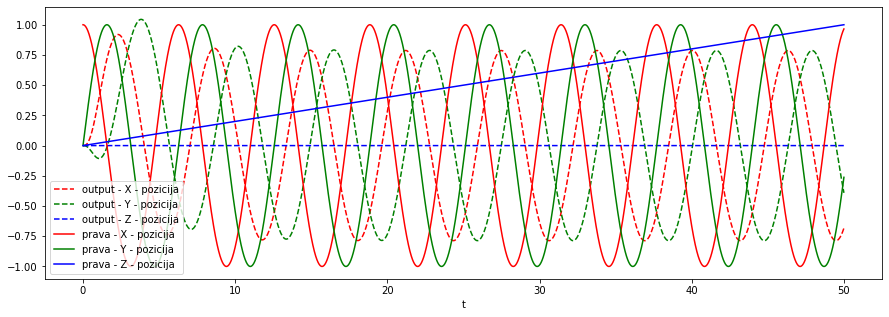

In [11]:
t_max = 50; t_intervals = 10000; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);

def uu(t):
    return [cos(t), sin(t), t / t_max, 0];

# Input
u = matrix(zeros((t_intervals, 1)));
U = matrix(list(map(uu, t)));
# Početno stanje.
x0 = matrix(zeros((14, 1)));
x0[0:4] = matrix([1, 1, 0, 0]).T;

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout, tout, xout] = lsim(sys_G, u, t, x0);

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 5)
f = figure;
plot(tout, yout[:, 0], 'r--', label = 'output - X - pozicija');
plot(tout, yout[:, 1], 'g--', label = 'output - Y - pozicija');
plot(tout, yout[:, 2], 'b--', label = 'output - Z - pozicija');
plot(tout, U[:, 0], 'r-', label = 'prava - X - pozicija');
plot(tout, U[:, 1], 'g-', label = 'prava - Y - pozicija');
plot(tout, U[:, 2], 'b-', label = 'prava - Z - pozicija');
xlabel('t');
legend();
show();

In [18]:
##### Alternativni servo kompenzator umjesto yr = const uzimamo yr = sin(t / t_max)

t_max = 1000; t_intervals = 10000; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);


Ap = block([
    [O44, -I4],
    [-I4, O44]
]);

Ap *= 1 / t_max;

Bp = block([
    [O44],
    [I4]
]);


tmp_A = block([[A, O128], 
               [-Bp * C, Ap]]);

tmp_B = block([[B], 
               [-Bp * D]]);


Q = matrix(diag([0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 100, 100, 100, 100, 100, 100, 100, 100]));

R = matrix(eye(4));

[_, _, G] = care(tmp_A, tmp_B, Q, R)

K = R @ G; #inv ne vraca matricu

# Spajanje sustava
Kx = K[:, 0:12];
Kni = K[:, 12:20];
Q.shape

(20, 20)

In [19]:
tmp_C = block([[I12], 
               [O412]]);

tmp_D = block([[O124], 
               [I4]]);

sys_G1 = ss(A, B, tmp_C, tmp_D);
sys_G2 = ss(0, O116, O41, block([[C, D]]));

sys_Kx  = ss(0, O116, O41, block([[Kx, O44]])); 
sys_Kni = ss(0, O18, O41, Kni);

# Kreiramo pomocne matrice za integrator

sys_int = ss(Ap, Bp, eye(8), ones((8, 4)));

sys_Id = ss(0, O14, O41, I4);
# Možemo složiti konačni sustav

sys_T1 = feedback(sys_G1, sys_Kx);
sys_T2 = series(sys_int, sys_Kni);
sys_T3 = series(sys_T2, sys_T1);
sys_T4 = series(sys_T3, sys_G2);
sys_G_servo = feedback(sys_T4, sys_Id, 1);

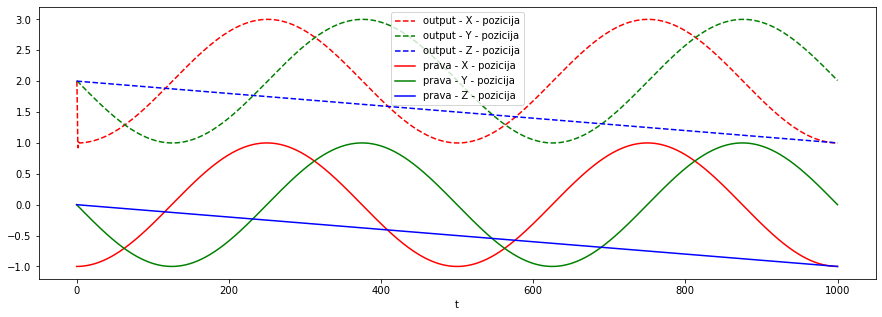

In [21]:
t_max = 1000; t_intervals = 10000; dt = t_max / t_intervals;
t = linspace(0, t_max, t_intervals);

def uu(t):
    return [cos(t / t_max * 4 * pi), sin(t / t_max * 4 * pi), t / t_max, 0];

# Input
u = matrix(list(map(uu, t)));
# Početno stanje.
x0 = matrix(zeros((20, 1)));

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout, tout, xout] = lsim(sys_G_servo, u, t, x0);

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 5)
f = figure;
plot(tout, yout[:, 0] + 2, 'r--', label = 'output - X - pozicija');
plot(tout, yout[:, 1] + 2, 'g--', label = 'output - Y - pozicija');
plot(tout, yout[:, 2] + 2, 'b--', label = 'output - Z - pozicija');
plot(tout, -u[:, 0], 'r-', label = 'prava - X - pozicija');
plot(tout, -u[:, 1], 'g-', label = 'prava - Y - pozicija');
plot(tout, -u[:, 2], 'b-', label = 'prava - Z - pozicija');
xlabel('t');
legend();
show();